In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import scipy.stats as stats
from scipy.stats import mannwhitneyu


data = pd.read_csv("HR_data.csv")

data

,Unnamed: 0,HR_Mean,HR_Median,HR_std,HR_Min,HR_Max,HR_AUC,Round,Phase,Individual,Puzzler,Frustrated,Cohort
0,0,77.965186,78.000,3.345290,73.23,83.37,22924.945,round_3,phase3,1,1,1,D1_1
1,1,70.981097,70.570,2.517879,67.12,78.22,21930.400,round_3,phase2,1,1,5,D1_1
2,2,73.371959,73.360,3.259569,67.88,80.22,21647.085,round_3,phase1,1,1,0,D1_1
3,3,78.916822,77.880,4.054595,72.32,84.92,25258.905,round_2,phase3,1,1,1,D1_1
4,4,77.322226,74.550,6.047603,70.52,90.15,23890.565,round_2,phase2,1,1,5,D1_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,163,73.594539,72.380,9.474556,57.43,93.53,21482.985,round_4,phase2,14,0,8,D1_2
164,164,57.839897,54.130,6.796647,52.97,74.14,16825.740,round_4,phase1,14,0,0,D1_2
165,165,64.237295,65.195,3.589241,58.97,72.63,18691.065,round_1,phase3,14,0,1,D1_2
166,166,70.834320,70.440,2.391160,66.65,76.07,20753.005,round_1,phase2,14,0,4,D1_2


In [130]:
X = data[['HR_Mean', 'HR_Min', 'HR_Max']]
y = data['Frustrated']
groups = data['Individual']

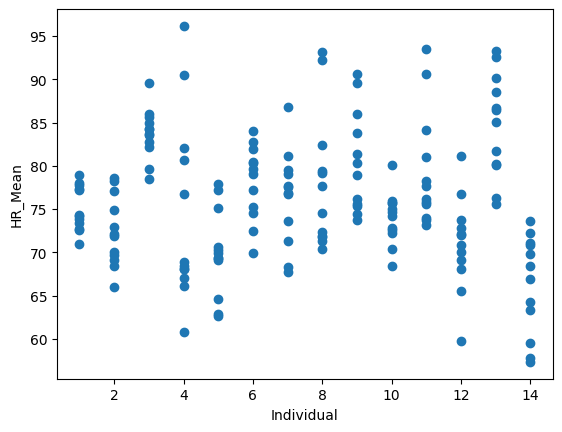

In [131]:
plt.scatter(groups, data["HR_Mean"])
plt.xlabel("Individual")
plt.ylabel("HR_Mean")
plt.show()

In [ ]:
model1 = RandomForestClassifier()
model2 = DecisionTreeClassifier()

results_model1 = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': []}
results_model2 = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'confusion_matrix': []}

logo = LeaveOneGroupOut()

for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Model 1
    model1.fit(X_train, y_train)
    y_pred = model1.predict(X_test)
    results_model1['accuracy'].append(accuracy_score(y_test, y_pred))
    results_model1['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    results_model1['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    results_model1['f1'].append(f1_score(y_test, y_pred, average='macro'))

    # Model 2
    model2.fit(X_train, y_train)
    y_pred = model2.predict(X_test)
    results_model2['accuracy'].append(accuracy_score(y_test, y_pred))
    results_model2['precision'].append(precision_score(y_test, y_pred, average='macro', zero_division=0))
    results_model2['recall'].append(recall_score(y_test, y_pred, average='macro', zero_division=0))
    results_model2['f1'].append(f1_score(y_test, y_pred, average='macro'))

def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    std_err = np.std(data) / np.sqrt(n)
    margin_of_error = std_err * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean - margin_of_error, mean + margin_of_error

metrics = ['accuracy', 'precision', 'recall', 'f1']

for metric in metrics:
    mean1 = np.mean(results_model1[metric])
    std1 = np.std(results_model1[metric])
    ci1 = confidence_interval(results_model1[metric])

    mean2 = np.mean(results_model2[metric])
    std2 = np.std(results_model2[metric])
    ci2 = confidence_interval(results_model2[metric])

    print(f'Model 1 - {metric.capitalize()}: Mean={mean1:.2f}, Std={std1:.2f}, CI=({ci1[0]:.2f}, {ci1[1]:.2f})')
    print(f'Model 2 - {metric.capitalize()}: Mean={mean2:.2f}, Std={std2:.2f}, CI=({ci2[0]:.2f}, {ci2[1]:.2f})')


print("------------------------------------------------------")

# manwhitney test

for metric in metrics:
    u_statistic, p_value = mannwhitneyu(results_model1[metric], results_model2[metric], alternative='two-sided')

    print(f'Mann-Whitney U test for {metric}: U={u_statistic:.2f}, p={p_value:.4f}')
